## Optimal Growth Temperature (OGT): phenotype prediction, feature selection, and data visualization

This notebook provides a pipeline for predicting the optimal growth temperature (OGT) and identifying genome footprints.

We train and test XGBoost regression on COG count tables, that are split into the test and train ones at a specified taxonomy level (i.e. all samples from a taxonomy group go to either train or test). The notebook can be run for one taxonomy level split.

To identify genome footprints and the most important features (COGs) contributing to the phenotype prediction, we use three different feature selection ranking methods:

- calculating the mutual information between the feature and the target label vector,
- using the feature weights returned by the random forest model,
- calculating SHAP values using the pre-trained XGBoost model.

The predictions of those three methods are compared between each other at the end of the notebook.

#### 1. Read the train and test datasets

First, we read the input files generated by *taxa_level_split.py*. The script generates 6 output files for the chosen [tax_level] of the train/test split, that are used as main inputs in this notebook. The files are the following:

- train_data_[tax_level]_tax_level : training count table,
- train_annot_[tax_level]_tax_level : training annotations,
- train_taxa_names_[tax_level]_tax_level : [tax_level] name of each training sample,

\+ 3 similar test tables. Those files should be stored in the corresponding directory for the phenotype.

In order to run the phenotype prediction pipeline in this notebook, the data directory with the input files, and [tax_level] of the train/test split should be specified below.

## Read the input data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "family" # <--------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_gc" # <-------- input data directory is here!!
NUM_SPLITS_TO_READ = 1  # <----------- number of splits to read and process is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/outputs/{TAX_LEVEL}"

In [2]:
from collections import defaultdict

all_splits_dict = defaultdict(int)
for split_id in range(NUM_SPLITS_TO_READ):
    # Read train data
    data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level_split_{split_id}"
    y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level_split_{split_id}"
    taxa_names_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level_split_{split_id}" if TAX_LEVEL != "random" else None
    X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)
    
    # Read test data
    data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level_split_{split_id}"
    y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level_split_{split_id}"
    taxa_names_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level_split_{split_id}" if TAX_LEVEL != "random" else None
    X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

    curr_split_dict = defaultdict(str)
    curr_split_dict["X_train"] = X_train
    curr_split_dict["y_train"] = y_train
    curr_split_dict["taxa_group_names_train"] = taxa_group_names_train
    curr_split_dict["X_test"] = X_test
    curr_split_dict["y_test"] = y_test
    curr_split_dict["taxa_group_names_test"] = taxa_group_names_test
    curr_split_dict["feature_names"] = X_column_names

    all_splits_dict[split_id] = curr_split_dict

In [3]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 52.70501708984375
Average OGT of the train set = 50.18800354003906


2984
750
4789


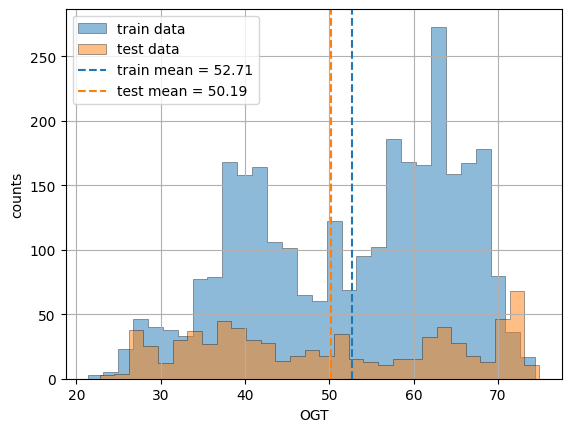

In [4]:
hist = plt.hist(y_train.cpu(), bins = 30, density = False, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
hist = plt.hist(y_test.cpu(), bins = 30, density = False, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:orange')
mean_value = y_train.cpu().mean().item()
plt.axvline(mean_value, color='tab:blue', linestyle='--', linewidth=1.5, label=f'train mean = {mean_value:.2f}')
mean_value = y_test.cpu().mean().item()
plt.axvline(mean_value, color='tab:orange', linestyle='--', linewidth=1.5, label=f'test mean = {mean_value:.2f}')


plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();
print(len(y_train.cpu()))
print(len(y_test.cpu()))
print(len(X_column_names))

#### 2. PCA and tSNE projections of the training data (colors = temperature)

In this section, we visualize all points from our datasets by projecting them into 2D PCA, and tSNE spaces. This projections give us insights on the structure of the datasets. 

First, we visualize the points and color them with respect to their OGTs.

In [5]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [6]:
# Concatenate train and test for the 2D visualization
y_label = torch.cat((y_train, y_test), dim=0)
X_val = torch.cat((X_train, X_test), dim=0)
if TAX_LEVEL != "random":
    taxa_group_names = taxa_group_names_train + taxa_group_names_test

Shape of the projected data = (3734, 2)


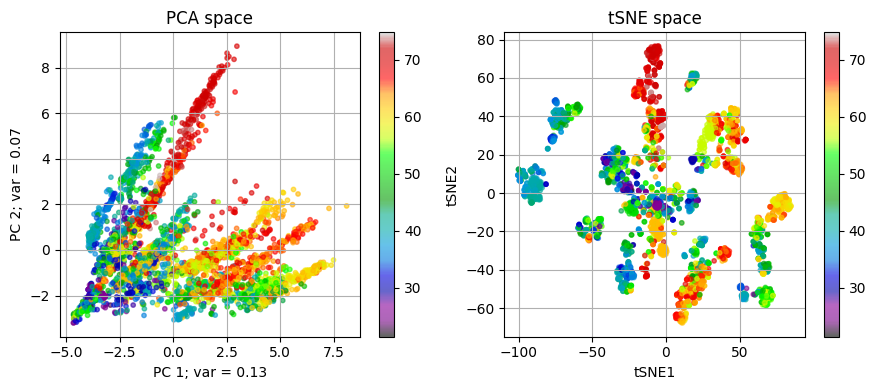

In [7]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
colorbar = True

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_val.cpu(), n_compon, y_label.cpu(), None, None, False, colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, y_label.cpu(), None, colorbar);


# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_orig_phenot.pdf", format="pdf")
plt.show()

Shape of the projected data = (3734, 2)


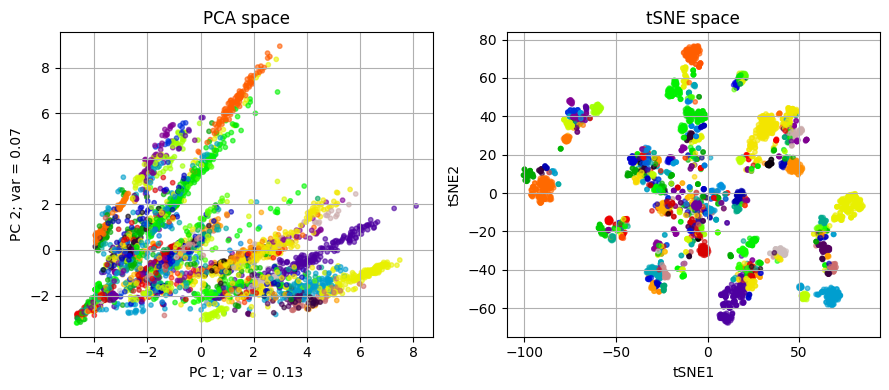

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

if TAX_LEVEL != "random":
    plt.figure(figsize=(9, 4))
    
    # PCA space
    plt.subplot(1, 2, 1) 
    n_compon = 10
    colors = None
    category_names = taxa_group_names
    pca_run_and_plot(X_val.cpu(), n_compon, label_encoder.fit_transform(category_names),
                     category_names, colors);
    # t-SNE space
    plt.subplot(1, 2, 2) 
    tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, label_encoder.fit_transform(category_names));
    
    # Display the plots
    plt.tight_layout()  
    plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_all_feat.pdf", format="pdf")
    plt.show()

## Initial prediction

In [9]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


XGBoost baseline test RMSE (all features) = 7.49, R2 = 0.76
XGBoost baseline CV RMSE (all features) = 4.21, R2 = 0.88


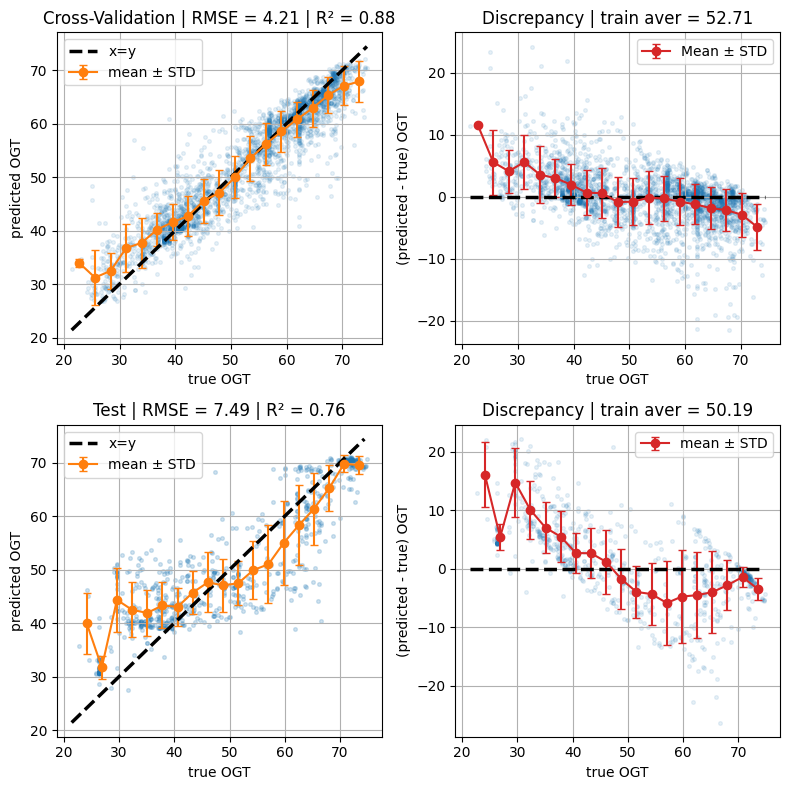

In [10]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers_cv_old, mean_diff_cv_old, std_diff_cv_old = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers_test_old, mean_diff_test_old, std_diff_test_old = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

## Step 2: Train Models on Data Segments

### Two class modelling

In [12]:
# Flatten y_train to 1D
y_train_flat = y_train.cpu().flatten()

# Compute quantiles from the flattened version
low_q = 50

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
high_mask = y_train_flat >= low_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask].cpu(), y_train_flat[low_mask].cpu()
X_high, y_high = X_train[high_mask].cpu(), y_train_flat[high_mask].cpu()



# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()

low_mask_test  = y_test_flat < low_q
high_mask_test = y_test_flat >= low_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test].cpu(), y_test_flat[low_mask_test].cpu()
X_test_high, y_test_high = X_test[high_mask_test].cpu(), y_test_flat[high_mask_test].cpu()

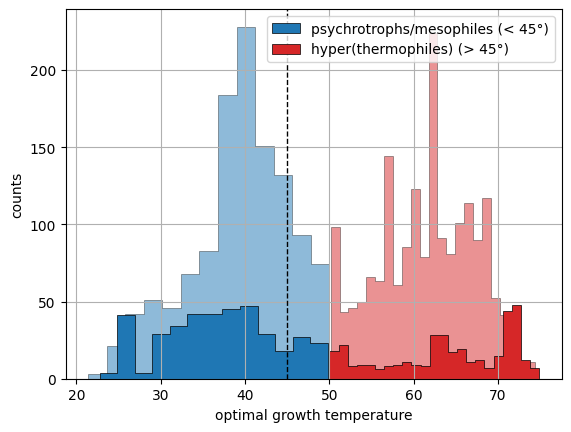

num low = 1176; num high = 1808;


In [13]:
#plt.figure(figsize=(5, 3))

plt.hist(y_low, bins=13, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
plt.hist(y_test_low, bins=13, label = "psychrotrophs/mesophiles (< 45°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
plt.hist(y_high, bins=23, alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:red')
plt.hist(y_test_high, bins=23, label = "hyper(thermophiles) (> 45°)", alpha = 1, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:red')
plt.axvline(45, color='black', linestyle='--', linewidth=1)

plt.grid(True)

plt.xlabel("optimal growth temperature")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

plt.savefig(f"{OUTPUT_DIRECTORY}/two_sample_classes.pdf", format="pdf")
plt.show()

print(f"num low = {len(y_low)}; num high = {len(y_high)};")

Shape of the projected data = (3734, 2)


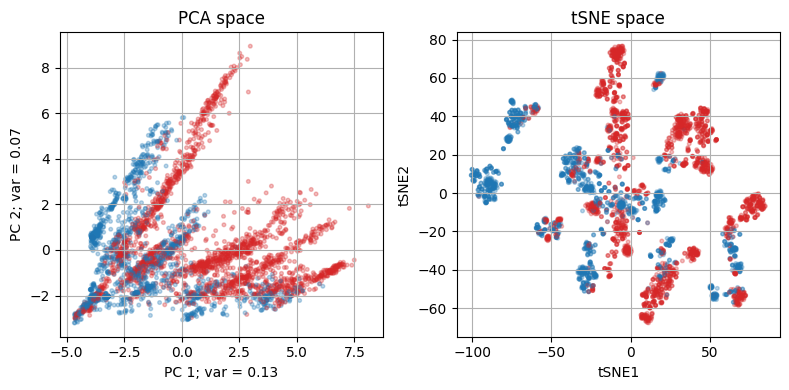

In [14]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [1 if yi > low_q else 0 for yi in y_label.cpu()]

colors = ListedColormap(["tab:blue", "tab:red"])

plt.figure(figsize=(8, 4))
colorbar = False

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_val.cpu(), n_compon, y_train_masked, None, colors, False, colorbar, alpha=0.3, s = 7);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, y_train_masked, colors, colorbar, alpha=0.3, s = 7);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_two_temp_ranges.pdf", format="pdf")
plt.show()

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


# --- 1. Label each sample as low, mid, or high OGT group
def label_ogt_range(y,high_thresh=45):
    labels = []
    for val in y:
        if val < high_thresh:
            labels.append('low')
        else:
            labels.append('high')
    return np.array(labels)

# Assign labels
range_labels = label_ogt_range(y_train)

le = LabelEncoder()
range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2

label_to_int = {'low': 0, 'high': 1}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)

range_labels_test = label_ogt_range(y_test)
range_ids_test = np.vectorize(label_to_int.get)(range_labels_test)

(array([329., 421.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

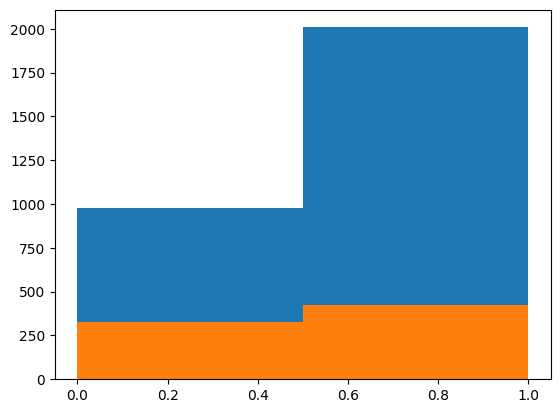

In [16]:
plt.hist(range_ids, bins=2)
plt.hist(range_ids_test, bins=2)

In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(range_ids)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)

# Convert to dictionary format for xgboost
class_weights = dict(zip(classes, weights))

# class_weights[0]=1
# class_weights[1]=10

# Pass weights to each sample
sample_weights = np.array([class_weights[c] for c in range_ids])

class_weights

{0: 1.528688524590164, 1: 0.7430278884462151}

In [25]:
def xgboost_mixture_of_experts_2_class(X_train, y_train, range_ids, sample_weights, X_test, y_test):

    num_classes = 2
    temp_bound = 45
    gating_model = XGBClassifier(
        n_jobs=-1,
        tree_method="hist",
        objective="binary:logistic",   # Binary classification objective
        eval_metric="logloss",         # Suitable for binary classification
    )

    gating_model.fit(X_train.cpu(), range_ids,sample_weight=sample_weights )  # Predicts soft assignments to experts

    # --- 4. Get gating probabilities (soft weights for each expert)
    gate_probs = gating_model.predict_proba(X_test.cpu())  # Shape: (n_samples, 3)
    gate_preds = gating_model.predict(X_test.cpu()) 

    y_train = y_train.squeeze()

    # Define masks (all 1D)
    low_mask  = y_train < temp_bound
    high_mask = y_train >= temp_bound

    # Apply masks correctly
    X_low, y_low   = X_train[low_mask].cpu(), y_train[low_mask].cpu()
    X_high, y_high = X_train[high_mask].cpu(), y_train[high_mask].cpu()

    model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
    model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)

    pred_low  = model_low.predict(X_test)
    pred_high = model_high.predict(X_test)

    final_pred = (
        gate_probs[:, 0]  * pred_low +
        gate_probs[:, 1] * pred_high
    )

    return gating_model, gate_probs, final_pred

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier, XGBRegressor
import numpy as np

def xgboost_mixture_of_experts_2_class_cv_full(X_train, y_train, range_ids, sample_weights, X_test, y_test, n_splits=5):
    num_classes = 2
    temp_bound = 45
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Convert to numpy
    X_train_np = X_train.cpu().numpy()
    y_train_np = y_train.cpu().numpy().flatten()
    X_test_np = X_test.cpu().numpy()
    sample_weights_np = sample_weights if isinstance(sample_weights, np.ndarray) else sample_weights.cpu().numpy()
    range_ids_np = range_ids if isinstance(range_ids, np.ndarray) else range_ids.cpu().numpy()

    final_cv_preds = np.zeros_like(y_train_np, dtype=float)
    true_cv_vals = np.zeros_like(y_train_np, dtype=float)
    gate_probs_cv = np.zeros((len(y_train_np), num_classes))

    gate_true_cv = np.zeros_like(y_train_np, dtype=int)  # Class labels: 0 (<45), 1 (≥45)
    gate_preds_cv = np.zeros_like(y_train_np, dtype=int)

    for train_index, val_index in kf.split(X_train_np):
        X_tr, X_val = X_train_np[train_index], X_train_np[val_index]
        y_tr, y_val = y_train_np[train_index], y_train_np[val_index]
        w_tr = sample_weights_np[train_index]
        r_tr = range_ids_np[train_index]

        # Train gating model
        gating_model = XGBClassifier(
            n_jobs=-1,
            tree_method="hist",
            objective="binary:logistic",
            eval_metric="logloss"
        )
        gating_model.fit(X_tr, r_tr, sample_weight=w_tr)
        gate_probs_val = gating_model.predict_proba(X_val)
        gate_preds_val = np.argmax(gate_probs_val, axis=1)

        # Define true class labels for gating
        gate_true_val = (y_val >= temp_bound).astype(int)

        # Store for metrics
        gate_preds_cv[val_index] = gate_preds_val
        gate_true_cv[val_index] = gate_true_val

        # Train expert models
        low_mask  = y_tr < temp_bound
        high_mask = y_tr >= temp_bound

        model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_tr[low_mask], y_tr[low_mask])
        model_high = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_tr[high_mask], y_tr[high_mask])

        pred_low  = model_low.predict(X_val)
        pred_high = model_high.predict(X_val)

        final_val_pred = gate_probs_val[:, 0] * pred_low + gate_probs_val[:, 1] * pred_high

        final_cv_preds[val_index] = final_val_pred
        true_cv_vals[val_index] = y_val
        gate_probs_cv[val_index] = gate_probs_val

    # CV metrics for gating model
    cv_metrics = {
        "accuracy": accuracy_score(gate_true_cv, gate_preds_cv),
        "precision": precision_score(gate_true_cv, gate_preds_cv),
        "recall": recall_score(gate_true_cv, gate_preds_cv),
        "f1": f1_score(gate_true_cv, gate_preds_cv)
    }

    # Train final gating model on full training set
    gating_model_full = XGBClassifier(
        n_jobs=-1,
        tree_method="hist",
        objective="binary:logistic",
        eval_metric="logloss"
    )
    gating_model_full.fit(X_train_np, range_ids_np, sample_weight=sample_weights_np)
    gate_probs_test = gating_model_full.predict_proba(X_test_np)
    gate_preds_test = np.argmax(gate_probs_test, axis=1)

  #  print(len(gate_preds_test))

    # True test class labels for gating (inferred from regression target y_train)
    gate_true_test = (y_test.cpu().numpy().flatten() >= temp_bound).astype(int)
 #   print(len(gate_true_test))
   # gate_true_test = (y_train_np >= temp_bound).astype(int)  # Train labels used to train experts

    # Train expert models on full training set
    low_mask  = y_train_np < temp_bound
    high_mask = y_train_np >= temp_bound

    model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_train_np[low_mask], y_train_np[low_mask])
    model_high = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_train_np[high_mask], y_train_np[high_mask])

    pred_low  = model_low.predict(X_test_np)
    pred_high = model_high.predict(X_test_np)

    final_test_pred = gate_probs_test[:, 0] * pred_low + gate_probs_test[:, 1] * pred_high

    test_metrics = {
        "accuracy": accuracy_score(gate_true_test, gate_preds_test),
        "precision": precision_score(gate_true_test, gate_preds_test),
        "recall": recall_score(gate_true_test, gate_preds_test),
        "f1": f1_score(gate_true_test, gate_preds_test)
    }

    return {
        "cv_predictions": final_cv_preds,
        "cv_true": true_cv_vals,
        "cv_gate_probs": gate_probs_cv,
        "test_predictions": final_test_pred,
        "gating_model": gating_model_full,
        "gate_probs_test": gate_probs_test,
        "cv_metrics": cv_metrics,
        "test_metrics": test_metrics
    }


In [27]:
gating_model, gate_probs, final_pred = xgboost_mixture_of_experts_2_class(X_train, y_train, range_ids, sample_weights, X_test, y_test)

In [28]:
dict_res_two_class = xgboost_mixture_of_experts_2_class_cv_full(X_train, y_train, range_ids, sample_weights, X_test, y_test)
dict_res_two_class["cv_metrics"]

{'accuracy': 0.9470509383378016,
 'precision': 0.9685916919959473,
 'recall': 0.952191235059761,
 'f1': 0.9603214465092919}

In [29]:
dict_res_two_class["test_metrics"]

{'accuracy': 0.8533333333333334,
 'precision': 0.8956743002544529,
 'recall': 0.836104513064133,
 'f1': 0.8648648648648649}

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       329
           1       0.90      0.84      0.86       421

    accuracy                           0.85       750
   macro avg       0.85      0.86      0.85       750
weighted avg       0.86      0.85      0.85       750



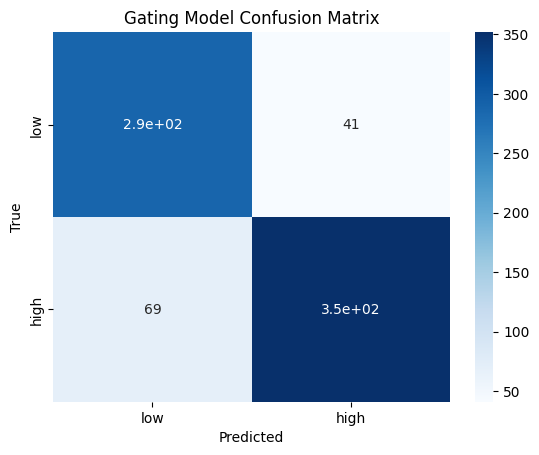

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

gate_preds = gating_model.predict(X_test.cpu()) 

print(classification_report(range_ids_test,gate_preds))

# Confusion matrix
cm = confusion_matrix(range_ids_test, gate_preds)

sns.heatmap(cm, annot=True, xticklabels=["low", "high"], yticklabels=["low", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

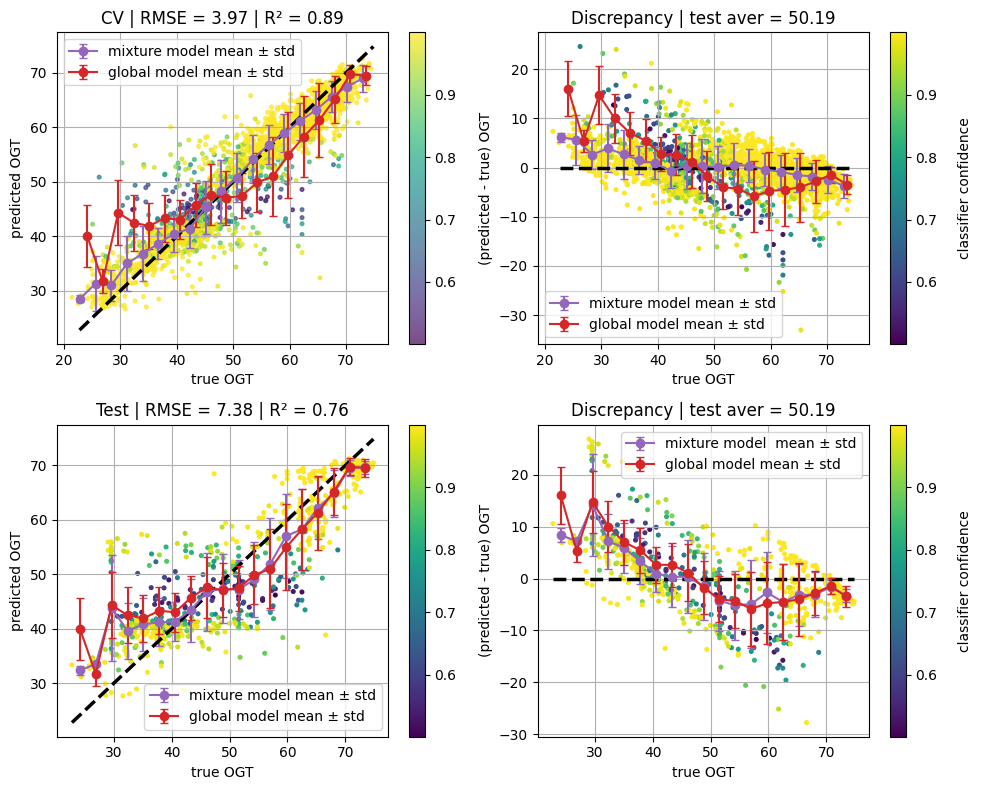

In [31]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


plt.figure(figsize=(10, 8))

y_test = y_test.cpu()
mx_prob = [max(g) for g in gate_probs]
mx_prob_cv = [max(g) for g in dict_res_two_class["cv_gate_probs"]]

num_bins = 20
min_temp = min(y_test.squeeze())
max_temp = max(y_test.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(dict_res_two_class["cv_true"], dict_res_two_class["cv_predictions"], marker='o', alpha = 0.7,c = mx_prob_cv, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(dict_res_two_class["cv_true"], dict_res_two_class["cv_predictions"], num_bins)
rmse_cv = np.sqrt(mean_squared_error(dict_res_two_class["cv_true"], dict_res_two_class["cv_predictions"]))
r2_cv = r2_score(dict_res_two_class["cv_true"], dict_res_two_class["cv_predictions"])
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model mean ± std')
plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"CV | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()

# Diff for full signal  
plt.subplot(2, 2, 2) 
y_test = y_test.cpu()
diff =  dict_res_two_class["cv_predictions"] - dict_res_two_class["cv_true"]#[dict_res["cv_predictions"] - dict_res["cv_true"] for i in range(len(dict_res["cv_predictions"]))]
bin_centers, mean_diff, std_diff = calculate_aver_std(dict_res_two_class["cv_true"], np.array([x.item() for x in diff]), num_bins)
plt.scatter(dict_res_two_class["cv_true"], diff, marker='o', alpha = 1, c = mx_prob_cv, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model mean ± std')
plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label("classifier confidence", rotation=90, labelpad=15)  # vertical title


# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 3) 
plt.scatter(y_test.cpu(), final_pred, marker='o', alpha = 1, c = mx_prob, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), final_pred, num_bins)
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze(), final_pred))
r2_test = r2_score(y_test.squeeze(), final_pred)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model mean ± std')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")

plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')
plt.legend()
plt.grid(True)
cbar = plt.colorbar()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [final_pred[i] - y_test[i] for i in range(len(final_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 1, c = mx_prob, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:purple', capsize=3, label='mixture model  mean ± std')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 

plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='global model mean ± std')

plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label("classifier confidence", rotation=90, labelpad=15)  # vertical title




# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/mixture_of_experts_2_class.pdf", format="pdf")
plt.show()

Top 20 important features:
COG1391: 0.1816
COG1643: 0.0448
COG4123: 0.0292
COG0140: 0.0196
COG0616: 0.0180
COG3816: 0.0146
COG0692: 0.0119
COG3745: 0.0110
COG1658: 0.0106
COG4980: 0.0105
COG0410: 0.0104
COG3839: 0.0098
COG3294: 0.0098
COG3082: 0.0093
COG0792: 0.0087
COG1174: 0.0086
COG0634: 0.0077
COG0667: 0.0073
COG0359: 0.0067
COG0606: 0.0065


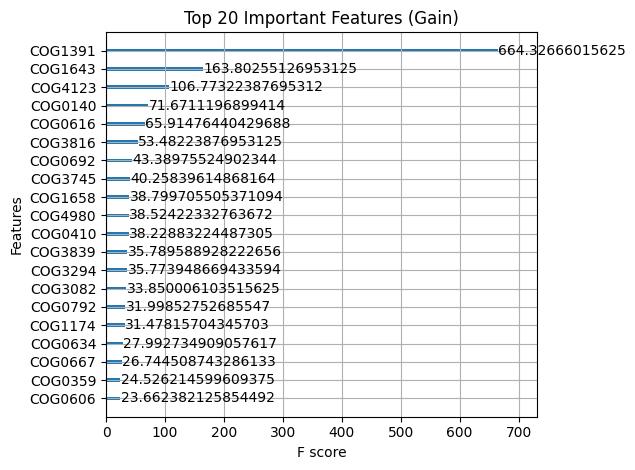

In [32]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances from trained model
importances = gating_model.feature_importances_

# Use your actual column names
feature_names = X_column_names  # Make sure it's a list of strings

# Pair and sort
feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: -x[1])

# Print top features
print("Top 20 important features:")
for feature, score in feature_importance_list[:20]:
    print(f"{feature}: {score:.4f}")

booster = gating_model.get_booster()

# Assign actual feature names
booster.feature_names = list(X_column_names)

# Plot
xgb.plot_importance(gating_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()



Average counts for top 20 features by class:
        COG1391   COG1643   COG4123   COG0140   COG0616   COG3816   COG0692  \
label                                                                         
0      0.182377  0.326844  0.892418  0.111680  0.898566  0.071721  0.818648   
1      0.781873  1.189741  0.504980  0.696215  1.287351  0.353586  0.650896   

        COG3745   COG1658   COG4980   COG0410   COG3839   COG3294   COG3082  \
label                                                                         
0      0.116803  0.474385  0.616803  0.589139  0.252049  0.040984  0.072746   
1      0.696215  0.081673  0.095618  3.893426  0.547311  0.048307  0.058765   

        COG0792   COG1174   COG0634   COG0667   COG0359   COG0606  
label                                                              
0      0.555328  0.559426  0.769467  1.607582  0.945697  0.690574  
1      0.878984  1.070717  0.752490  5.103087  0.919323  1.031873  


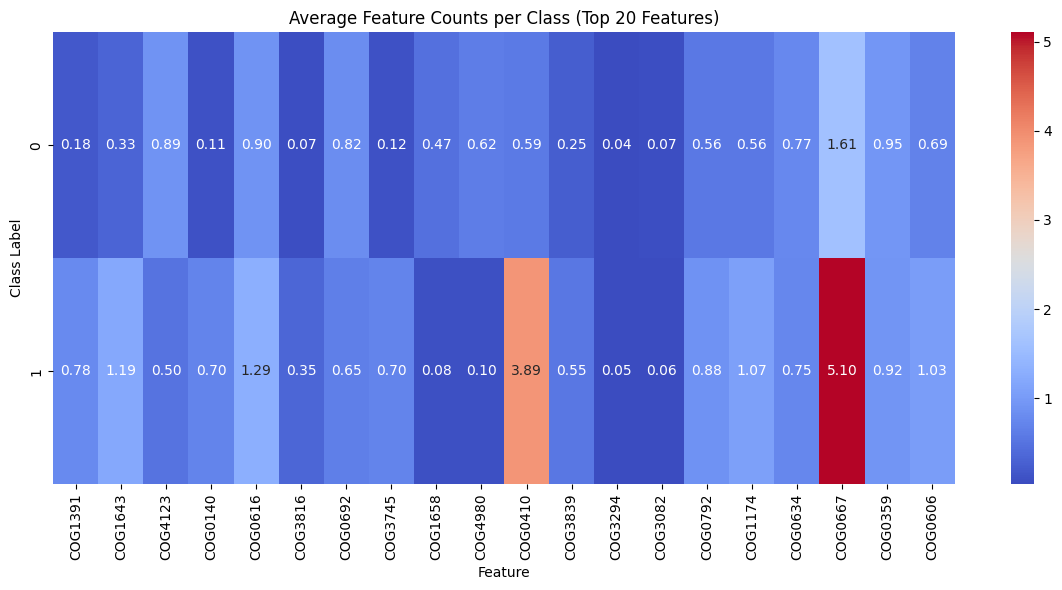

In [33]:
import numpy as np
import pandas as pd

# Convert to DataFrame for easier handling
df = pd.DataFrame(X_train.cpu(), columns=X_column_names)
df['label'] = range_ids

# Top 20 important features
top_features = [f for f, _ in feature_importance_list[:20]]

# Compute average counts for each class
grouped_means = df.groupby('label')[top_features].mean()

# Print results
print("\nAverage counts for top 20 features by class:")
print(grouped_means)

# Optional: visualize as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_means, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Feature Counts per Class (Top 20 Features)")
plt.xlabel("Feature")
plt.ylabel("Class Label")
plt.tight_layout()
plt.show()


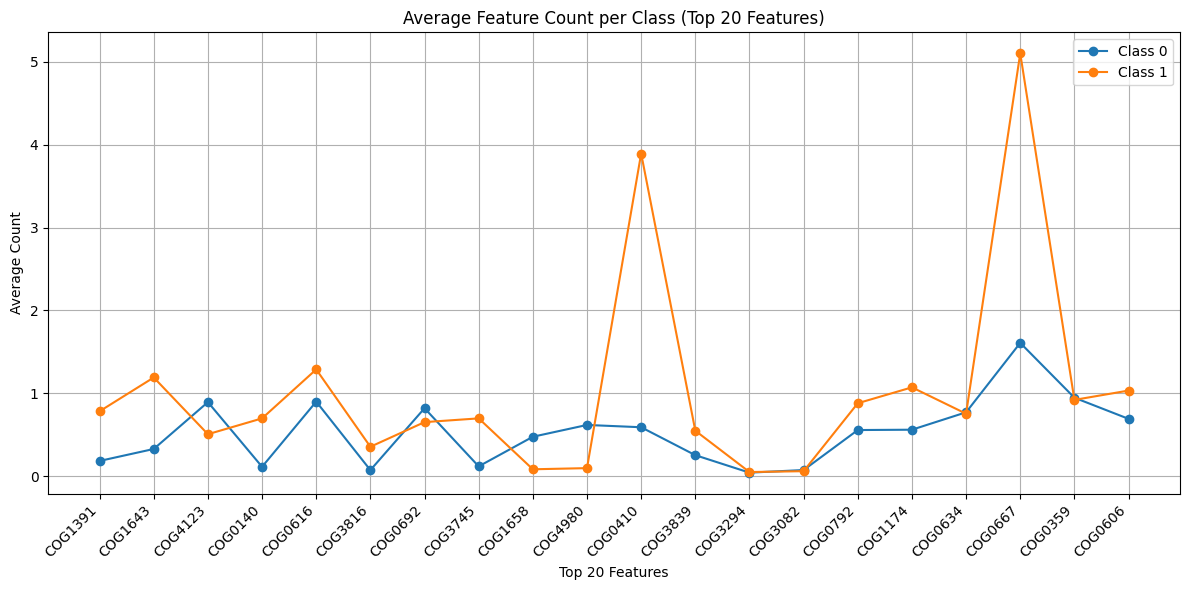

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame if not already
df = pd.DataFrame(X_train.cpu(), columns=X_column_names)
df['label'] = range_ids

# Get top 20 important features
top_features = [f for f, _ in feature_importance_list[:20]]

# Compute mean feature values per class
grouped_means = df.groupby('label')[top_features].mean()

# Plot lines for each class
plt.figure(figsize=(12, 6))

for class_label in grouped_means.index:
    plt.plot(top_features, grouped_means.loc[class_label], marker='o', label=f'Class {class_label}')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Top 20 Features")
plt.ylabel("Average Count")
plt.title("Average Feature Count per Class (Top 20 Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


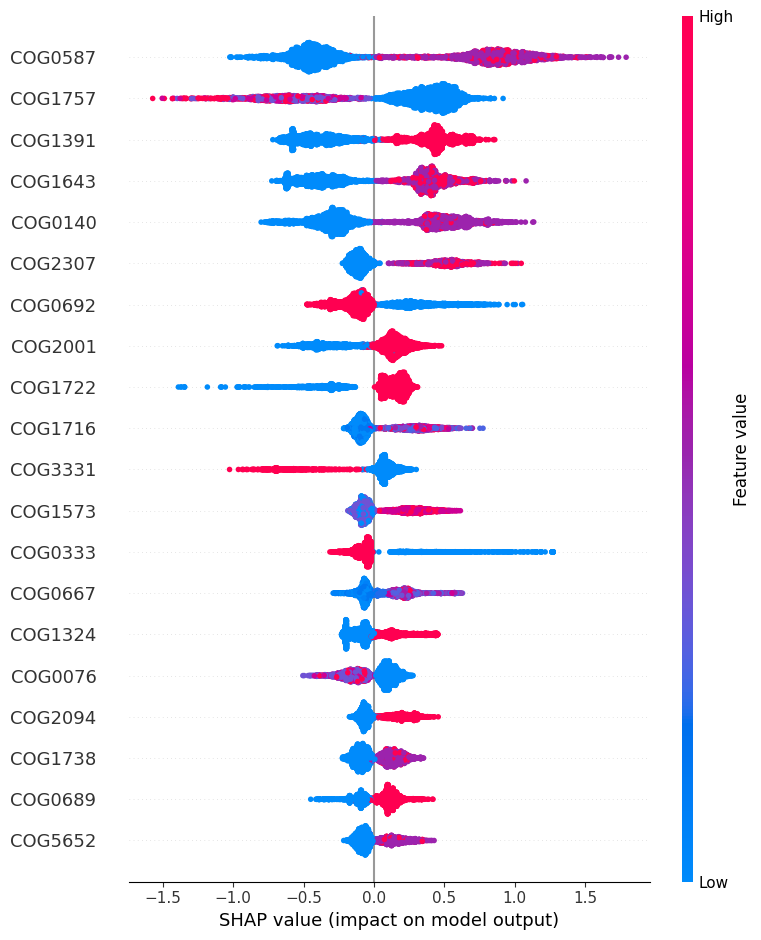

In [58]:
import pandas as pd
import shap

X_train = X_train.cpu()

# If X_train is a NumPy array, convert it:
X_train_df = pd.DataFrame(X_val.cpu(), columns=X_column_names)

# Recompute SHAP values if needed
explainer = shap.TreeExplainer(gating_model)
shap_values = explainer.shap_values(X_train_df)

# If it's a binary classifier:
shap.summary_plot(shap_values, X_train_df)


(array([  12.,   26.,  135.,  378.,  964., 1180.,  708.,  266.,   54.,
          11.]),
 array([17.26398087, 17.73871994, 18.21345901, 18.68819809, 19.16293716,
        19.63767624, 20.11241722, 20.5871563 , 21.06189537, 21.53663445,
        22.01137352]),
 <BarContainer object of 10 artists>)

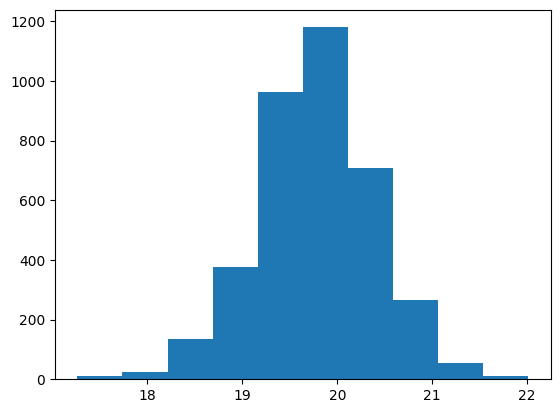

In [61]:
shap_sum_per_sample = np.abs(shap_values).sum(axis=1)
plt.hist(shap_sum_per_sample)

Shape of the projected data = (3734, 2)


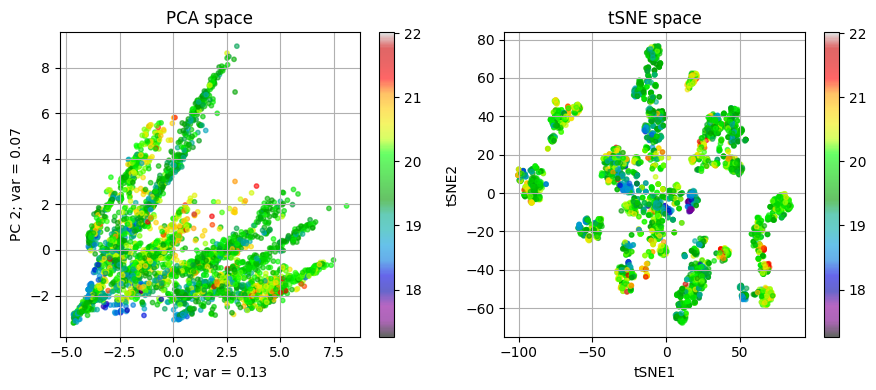

In [60]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
colorbar = True

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_val.cpu(), n_compon, shap_sum_per_sample, None, None, False, colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val.cpu(), 50, 100, RANDOM_SEED, shap_sum_per_sample, None, colorbar);


# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_shap_sum.pdf", format="pdf")
plt.show()

# Feature selection

In [39]:
from tqdm import tqdm


def xgboost_accuracy_multi_expert(X_train, X_test, y_train, y_test, sorted_cog_idx, feat_step, feat_removal = False):
    rmse_test_arr = []
    r2_test_arr = []
    rmse_cv_arr = []
    r2_cv_arr = []

    gating_accur_cv_arr = []
    gating_precision_cv_arr = []
    gating_recall_cv_arr = []
    gating_f1_cv_arr = []

    gating_accur_test_arr = []
    gating_precisio_test_arr = []
    gating_recall_test_arr = []
    gating_f1_test_arr = []
    
    num_feat = range(1,len(sorted_cog_idx),feat_step)
    num_feat_plot = []
    for N in tqdm(num_feat, desc="Running mixture of experts..."):
   # for N in num_feat:
        if feat_removal == False:
            select_feat = list(sorted_cog_idx[:N])
        else:
            select_feat = list(sorted_cog_idx[N:])
        num_feat_plot.append(N)#len(select_feat))    
        X_train_select_feat = X_train[:, select_feat]
        X_test_select_feat = X_test[:, select_feat]

        dict_res_two_class = xgboost_mixture_of_experts_2_class_cv_full(X_train_select_feat, y_train, range_ids, sample_weights, X_test_select_feat, y_test)

        rmse_test = np.sqrt(mean_squared_error(y_test, dict_res_two_class["test_predictions"]))
        rmse_test_arr.append(rmse_test)
        r2_test = r2_score(y_test, dict_res_two_class["test_predictions"])
        r2_test_arr.append(r2_test)
        
        rmse_cv = np.sqrt(mean_squared_error(dict_res_two_class["cv_true"], dict_res_two_class["cv_predictions"]))
        rmse_cv_arr.append(rmse_cv)
        r2_cv = r2_score(dict_res_two_class["cv_true"], dict_res_two_class["cv_predictions"])
        r2_cv_arr.append(r2_cv)
        
        gating_accur_cv_arr.append(dict_res_two_class["cv_metrics"]["accuracy"])  
        gating_precision_cv_arr.append(dict_res_two_class["cv_metrics"]["precision"])
        gating_recall_cv_arr.append(dict_res_two_class["cv_metrics"]["recall"])
        gating_f1_cv_arr.append(dict_res_two_class["cv_metrics"]["f1"])
    
        gating_accur_test_arr.append(dict_res_two_class["test_metrics"]["accuracy"])
        gating_precisio_test_arr.append(dict_res_two_class["test_metrics"]["precision"])
        gating_recall_test_arr.append(dict_res_two_class["test_metrics"]["recall"])
        gating_f1_test_arr.append(dict_res_two_class["test_metrics"]["f1"])

    gating_cv_metrics = {
        "accuracy_arr": gating_accur_cv_arr,
        "precision_arr": gating_precision_cv_arr,
        "recall_arr": gating_recall_cv_arr,
        "f1_arr": gating_f1_cv_arr
    }

    gating_test_metrics = {
        "accuracy_arr": gating_accur_test_arr,
        "precision_arr": gating_precisio_test_arr,
        "recall_arr": gating_recall_test_arr,
        "f1_arr": gating_f1_test_arr
    }
    
    return rmse_test_arr, r2_test_arr, rmse_cv_arr, r2_cv_arr, num_feat_plot, gating_cv_metrics, gating_test_metrics

In [40]:
def random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal):
    tot_num_feat = X_train.cpu().shape[1]
    rmse_test_arr_mi_tot = []
    r2_test_arr_mi_tot = []
    rmse_cv_arr_mi_tot = []
    r2_cv_arr_mi_tot = []

    gating_accur_cv_tot = []
    gating_preci_cv_tot = []
    gating_recall_cv_tot = []
    gating_f1_cv_tot = []

    gating_accur_test_tot = []
    gating_preci_test_tot = []
    gating_recall_test_tot = []
    gating_f1_test_tot = []
    
    range_labels = label_ogt_range(y_train)
    le = LabelEncoder()
    range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2
    label_to_int = {'low': 0, 'high': 1}
    range_ids = np.vectorize(label_to_int.get)(range_labels)

    for _ in range(num_runs):
        shuffled_indices = np.random.permutation(tot_num_feat)

        rmse_test_arr_mi, r2_test_arr_mi, rmse_cv_arr_mi, r2_cv_arr_mi, num_feat_plot, gating_cv_metrics, gating_test_metrics = xgboost_accuracy_multi_expert(X_train.cpu(), X_test.cpu(), y_train, y_test, shuffled_indices, feat_step, feat_removal)
        rmse_test_arr_mi_tot.append(rmse_test_arr_mi)
        r2_test_arr_mi_tot.append(r2_test_arr_mi)
        rmse_cv_arr_mi_tot.append(rmse_cv_arr_mi)
        r2_cv_arr_mi_tot.append(r2_cv_arr_mi)

        gating_accur_cv_tot.append(gating_cv_metrics["accuracy_arr"])
        gating_preci_cv_tot.append(gating_cv_metrics["precision_arr"])
        gating_recall_cv_tot.append(gating_cv_metrics["recall_arr"])
        gating_f1_cv_tot.append(gating_cv_metrics["f1_arr"])
        
        gating_accur_test_tot.append(gating_test_metrics["accuracy_arr"])
        gating_preci_test_tot.append(gating_test_metrics["precision_arr"])
        gating_recall_test_tot.append(gating_test_metrics["recall_arr"])
        gating_f1_test_tot.append(gating_test_metrics["f1_arr"])
        
    rmse_test_arr_mi_mean = np.array(rmse_test_arr_mi_tot).mean(axis=0)  
    rmse_test_arr_mi_std = np.array(rmse_test_arr_mi_tot).std(axis=0)  
    
    r2_test_arr_mi_mean = np.array(r2_test_arr_mi_tot).mean(axis=0)  
    r2_test_arr_mi_std = np.array(r2_test_arr_mi_tot).std(axis=0)  
    
    rmse_cv_arr_mi_mean = np.array(rmse_cv_arr_mi_tot).mean(axis=0)  
    rmse_cv_arr_mi_std = np.array(rmse_cv_arr_mi_tot).std(axis=0)  
    
    r2_cv_arr_mi_mean = np.array(r2_cv_arr_mi_tot).mean(axis=0)  
    r2_cv_arr_mi_std = np.array(r2_cv_arr_mi_tot).std(axis=0)  

    rmse_test_curve = {"mean": rmse_test_arr_mi_mean, "std": rmse_test_arr_mi_std}
    r2_test_curve = {"mean": r2_test_arr_mi_mean, "std": r2_test_arr_mi_std}
    rmse_cv_curve = {"mean": rmse_cv_arr_mi_mean, "std": rmse_cv_arr_mi_std}
    r2_cv_curve = {"mean": r2_cv_arr_mi_mean, "std": r2_cv_arr_mi_std}

    gating_accur_cv_mean = np.array(gating_accur_cv_tot).mean(axis=0)  
    gating_accur_cv_std = np.array(gating_accur_cv_tot).std(axis=0) 
    gating_accur_cv_curve = {"mean": gating_accur_cv_mean, "std": gating_accur_cv_std}
    
    gating_preci_cv_mean = np.array(gating_preci_cv_tot).mean(axis=0)  
    gating_preci_cv_std = np.array(gating_preci_cv_tot).std(axis=0) 
    gating_preci_cv_curve = {"mean": gating_preci_cv_mean, "std": gating_preci_cv_std}
    
    gating_recall_cv_mean = np.array(gating_recall_cv_tot).mean(axis=0)  
    gating_recall_cv_std = np.array(gating_recall_cv_tot).std(axis=0) 
    gating_recall_cv_curve = {"mean": gating_recall_cv_mean, "std": gating_recall_cv_std}
    
    gating_f1_cv_mean = np.array(gating_f1_cv_tot).mean(axis=0)  
    gating_f1_cv_std = np.array(gating_f1_cv_tot).std(axis=0) 
    gating_f1_cv_curve = {"mean": gating_f1_cv_mean, "std": gating_f1_cv_std}
    
    gating_accur_test_mean = np.array(gating_accur_test_tot).mean(axis=0)  
    gating_accur_test_std = np.array(gating_accur_test_tot).std(axis=0) 
    gating_accur_test_curve = {"mean": gating_accur_test_mean, "std": gating_accur_test_std}

    gating_preci_test_mean = np.array(gating_preci_test_tot).mean(axis=0)  
    gating_preci_test_std = np.array(gating_preci_test_tot).std(axis=0) 
    gating_preci_test_curve = {"mean": gating_preci_test_mean, "std": gating_preci_test_std}

    gating_recall_test_mean = np.array(gating_recall_test_tot).mean(axis=0)  
    gating_recall_test_std = np.array(gating_recall_test_tot).std(axis=0) 
    gating_recall_test_curve = {"mean": gating_recall_test_mean, "std": gating_recall_test_std}

    gating_f1_test_mean = np.array(gating_f1_test_tot).mean(axis=0)  
    gating_f1_test_std = np.array(gating_f1_test_tot).std(axis=0) 
    gating_f1_test_curve = {"mean": gating_f1_test_mean, "std": gating_f1_test_std}
    
    return rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve

In [41]:
num_runs = 5
feat_step = 100

feat_removal = False
rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve = random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal)





C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

unning mixture of experts...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [09:46<00:00, 12.22s/it]

In [42]:
feat_removal = True
rmse_test_curve_rem, r2_test_curve_rem, rmse_cv_curve_rem, r2_cv_curve_rem, gating_accur_cv_curve_rem, gating_preci_cv_curve_rem, gating_recall_cv_curve_rem, gating_f1_cv_curve_rem, gating_accur_test_curve_rem, gating_preci_test_curve_rem, gating_recall_test_curve_rem, gating_f1_test_curve_rem  = random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal)




Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000001D6DBE43C50>>
Traceback (most recent call last):
  File "C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 

unning mixture of experts...:  10%|███████████▊                                                                                                     | 5/48 [02:22<20:27, 28.54s/it]

XGBoostError: [17:02:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\iterative_dmatrix.cc:263: Check failed: rbegin == Info().num_row_ (4016 vs. 2008) : 

## Mutual info

In [ ]:
X_train_np = np.array(X_train)
X_train_transposed = X_train_np.T
print(f"X_train_transposed shape = {X_train_transposed.shape}")

In [ ]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train.cpu(), y_train.squeeze().cpu(), X_column_names, RANDOM_SEED, contin_flag = True)

In [ ]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(len(top_feat_mi_counts[0]))

print(f"Top {N} COGs:", top_N_names_by_mi)

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 100
feat_removal = False
rmse_test_arr_mi_add, r2_test_arr_mi_add, rmse_cv_arr_mi_add, r2_cv_arr_mi_add, num_feat_plot, gating_cv_metrics, gating_test_metrics = xgboost_accuracy_multi_expert(X_train.cpu(), X_test.cpu(), y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [ ]:
len(rmse_cv_curve["mean"])
len(num_feat_plot)

In [ ]:
plt.figure(figsize=(10,3.5))

plt.subplot(1,2,1) 
plt.axhline(y=rmse_cv, color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=rmse_test, color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_plot, rmse_cv_arr_mi_add, color='tab:blue', label = "cv MI order", linewidth=1.5)
plt.plot(num_feat_plot, rmse_test_arr_mi_add, color='tab:orange', label = "test MI order", linewidth=1.5)
plt.plot(num_feat_plot, rmse_cv_curve["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_plot, rmse_cv_curve["mean"] - rmse_cv_curve["std"], rmse_cv_curve["mean"] + rmse_cv_curve["std"], alpha=0.2, color='tab:green')
plt.plot(num_feat_plot, rmse_test_curve["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_plot, rmse_test_curve["mean"] - rmse_test_curve["std"], rmse_test_curve["mean"] + rmse_test_curve["std"], alpha=0.2, color='tab:purple')


plt.xscale("log")
plt.xlabel("number of features added")
plt.title("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2) 
plt.axhline(y=r2_cv, color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=r2_test, color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_plot, r2_test_arr_mi_add, color='tab:orange', label = "test MI order", linewidth=1.5)
plt.plot(num_feat_plot, r2_cv_arr_mi_add, color='tab:blue', label = "cv MI order", linewidth=1.5)

plt.plot(num_feat_plot, r2_cv_curve["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_plot, r2_cv_curve["mean"] - r2_cv_curve["std"], r2_cv_curve["mean"] + r2_cv_curve["std"], alpha=0.2, color='tab:green')
plt.plot(num_feat_plot, r2_test_curve["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_plot, r2_test_curve["mean"] - r2_test_curve["std"], r2_test_curve["mean"] + r2_test_curve["std"], alpha=0.2, color='tab:purple')
plt.xscale("log")
plt.xlabel("number of features added")
plt.title(r"$R^2$")
plt.grid(True)
#plt.legend()
plt.tight_layout() 
plt.savefig(f"{OUTPUT_DIRECTORY}/rmse_r2_feat_added.pdf", format="pdf")  

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1) 
plt.axhline(y=dict_res_two_class["cv_metrics"]["accuracy"], color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=dict_res_two_class["test_metrics"]["accuracy"], color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_plot, gating_cv_metrics['accuracy_arr'], color='tab:orange', label = "cv MI order", linewidth=1.5)
plt.plot(num_feat_plot, gating_test_metrics['accuracy_arr'], color='tab:blue', label = "test MI order", linewidth=1.5)

#rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve 
plt.plot(num_feat_plot, gating_accur_cv_curve["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_plot, gating_accur_cv_curve["mean"] - gating_accur_cv_curve["std"], gating_accur_cv_curve["mean"] + gating_accur_cv_curve["std"], alpha=0.2, color='tab:green')
plt.plot(num_feat_plot, gating_accur_test_curve["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_plot, gating_accur_test_curve["mean"] - gating_accur_test_curve["std"], gating_accur_test_curve["mean"] + gating_accur_test_curve["std"], alpha=0.2, color='tab:purple')

plt.xscale("log")
plt.xlabel("number of features added")
plt.title("Accuracy")
plt.grid(True)
plt.legend()


plt.subplot(2,2,2) 
plt.axhline(y=dict_res_two_class["cv_metrics"]["precision"], color='black', linestyle='--', linewidth=1.5, label='cv baseline (all features)')
plt.axhline(y=dict_res_two_class["test_metrics"]["precision"], color='red', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.plot(num_feat_plot, gating_cv_metrics['precision_arr'], color='tab:orange', label = "gating accuracy cv", linewidth=1.5)
plt.plot(num_feat_plot, gating_test_metrics['precision_arr'], color='tab:blue', label = "gating accuracy test", linewidth=1.5)

#rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve 
plt.plot(num_feat_plot, gating_preci_cv_curve["mean"], label="cv random, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_plot, gating_preci_cv_curve["mean"] - gating_preci_cv_curve["std"], gating_preci_cv_curve["mean"] + gating_preci_cv_curve["std"], alpha=0.2, color='tab:green')
plt.plot(num_feat_plot, gating_preci_test_curve["mean"], label="test random, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_plot, gating_preci_test_curve["mean"] - gating_preci_test_curve["std"], gating_preci_test_curve["mean"] + gating_preci_test_curve["std"], alpha=0.2, color='tab:purple')

plt.xscale("log")
plt.xlabel("number of features added")
plt.title("Precision")
plt.grid(True)

plt.subplot(2,2,3) 
plt.axhline(y=dict_res_two_class["cv_metrics"]["recall"], color='black', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.axhline(y=dict_res_two_class["test_metrics"]["recall"], color='red', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.plot(num_feat_plot, gating_cv_metrics['recall_arr'], color='tab:orange', label = "gating accuracy cv", linewidth=1.5)
plt.plot(num_feat_plot, gating_test_metrics['recall_arr'], color='tab:blue', label = "gating accuracy test", linewidth=1.5)

#rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve 
plt.plot(num_feat_plot, gating_recall_cv_curve["mean"], label="cv random, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_plot, gating_recall_cv_curve["mean"] - gating_recall_cv_curve["std"], gating_recall_cv_curve["mean"] + gating_recall_cv_curve["std"], alpha=0.2, color='tab:green')
plt.plot(num_feat_plot, gating_recall_test_curve["mean"], label="test random, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_plot, gating_recall_test_curve["mean"] - gating_recall_test_curve["std"], gating_recall_test_curve["mean"] + gating_recall_test_curve["std"], alpha=0.2, color='tab:purple')
plt.xscale("log")

plt.xscale("log")
plt.xlabel("number of features added")
plt.title("Recall")
plt.grid(True)

plt.subplot(2,2,4)
plt.axhline(y=dict_res_two_class["cv_metrics"]["f1"], color='black', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.axhline(y=dict_res_two_class["cv_metrics"]["f1"], color='red', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.plot(num_feat_plot, gating_cv_metrics['f1_arr'], color='tab:orange', label = "gating accuracy cv", linewidth=1.5)
plt.plot(num_feat_plot, gating_test_metrics['f1_arr'], color='tab:blue', label = "gating accuracy test", linewidth=1.5)

#rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve 
plt.plot(num_feat_plot, gating_f1_cv_curve["mean"], label="cv random, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_plot, gating_f1_cv_curve["mean"] - gating_f1_cv_curve["std"], gating_f1_cv_curve["mean"] + gating_f1_cv_curve["std"], alpha=0.2, color='tab:green')
plt.plot(num_feat_plot, gating_f1_test_curve["mean"], label="test random, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_plot, gating_f1_test_curve["mean"] - gating_f1_test_curve["std"], gating_f1_test_curve["mean"] + gating_f1_test_curve["std"], alpha=0.2, color='tab:purple')

#plt.ylim([0.5, 1])
plt.xlabel("number of features added")
plt.title("F1")
plt.grid(True)

plt.xscale("log")
#plt.yscale("log")

plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/gating_accur_feat_added.pdf", format="pdf")  

In [ ]:
dict_res_two_class["cv_metrics"]

In [ ]:
dict_res_two_class["test_metrics"]

In [ ]:
feat_removal = True
rmse_test_arr_mi_rem, r2_test_arr_mi_rem, rmse_cv_arr_mi_rem, r2_cv_arr_mi_rem, num_feat_plot_rem, gating_cv_metrics_rem, gating_test_metrics_rem = xgboost_accuracy_multi_expert(X_train.cpu(), X_test.cpu(), y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [ ]:
plt.figure(figsize=(10,3.5))

tot_num_feat = X_train.cpu().shape[1]
num_feat_kept = [tot_num_feat - n  for n in num_feat_plot_rem]

plt.subplot(1,2,1) 
plt.axhline(y=rmse_cv, color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=rmse_test, color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_kept, rmse_cv_arr_mi_rem, color='tab:blue', label = "cv MI order", linewidth=1.5)
plt.plot(num_feat_kept, rmse_test_arr_mi_rem, color='tab:orange', label = "test MI order", linewidth=1.5)

#rmse_test_curve, r2_test_curve, rmse_cv_curve, r2_cv_curve, gating_accur_cv_curve, gating_preci_cv_curve, gating_recall_cv_curve, gating_f1_cv_curve, gating_accur_test_curve, gating_preci_test_curve, gating_recall_test_curve, gating_f1_test_curve 
plt.plot(num_feat_kept, rmse_cv_curve_rem["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_kept, rmse_cv_curve_rem["mean"] - rmse_cv_curve_rem["std"], rmse_cv_curve_rem["mean"] + rmse_cv_curve_rem["std"], alpha=0.3, color='tab:green')
plt.plot(num_feat_kept, rmse_test_curve_rem["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_kept, rmse_test_curve_rem["mean"] - rmse_test_curve_rem["std"], rmse_test_curve_rem["mean"] + rmse_test_curve_rem["std"], alpha=0.3, color='tab:purple')
#plt.xscale("log")
plt.xlabel("number of features kept")
plt.title("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2) 
plt.axhline(y=r2_cv, color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=r2_test, color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_kept, r2_cv_arr_mi_rem, color='tab:blue', label = "cv MI order", linewidth=1.5)
plt.plot(num_feat_kept, r2_test_arr_mi_rem, color='tab:orange', label = "test MI order", linewidth=1.5)

plt.plot(num_feat_kept, r2_cv_curve_rem["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_kept, r2_cv_curve_rem["mean"] - r2_cv_curve_rem["std"], r2_cv_curve_rem["mean"] + r2_cv_curve_rem["std"], alpha=0.3, color='tab:green')
plt.plot(num_feat_kept, r2_test_curve_rem["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_kept, r2_test_curve_rem["mean"] - r2_test_curve_rem["std"], r2_test_curve_rem["mean"] + r2_test_curve_rem["std"], alpha=0.3, color='tab:purple')

#plt.xscale("log")
plt.xlabel("number of features kept")
plt.title("R2")
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIRECTORY}/rmse_r2_feat_removed.pdf", format="pdf")  

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1) 
plt.axhline(y=dict_res_two_class["cv_metrics"]["accuracy"], color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=dict_res_two_class["test_metrics"]["accuracy"], color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_kept, gating_cv_metrics_rem['accuracy_arr'], color='tab:orange', label = "cv MI order", linewidth=1.5)
plt.plot(num_feat_kept, gating_test_metrics_rem['accuracy_arr'], color='tab:blue', label = "test  MI order", linewidth=1.5)

plt.plot(num_feat_kept, gating_accur_cv_curve_rem["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_kept, gating_accur_cv_curve_rem["mean"] - gating_accur_cv_curve_rem["std"], gating_accur_cv_curve_rem["mean"] + gating_accur_cv_curve_rem["std"], alpha=0.3, color='tab:green')
plt.plot(num_feat_kept, gating_accur_test_curve_rem["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_kept, gating_accur_test_curve_rem["mean"] - gating_accur_test_curve_rem["std"], gating_accur_test_curve_rem["mean"] + gating_accur_test_curve_rem["std"], alpha=0.3, color='tab:purple')

#plt.xscale("log")
plt.xlabel("number of features kept")
plt.title("Accuracy")
plt.grid(True)
plt.legend()


plt.subplot(2,2,2) 
plt.axhline(y=dict_res_two_class["cv_metrics"]["precision"], color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=dict_res_two_class["test_metrics"]["precision"], color='red', linestyle='--', linewidth=1.5, label='test all features')
plt.plot(num_feat_kept, gating_cv_metrics_rem['precision_arr'], color='tab:orange', label = "cv MI order", linewidth=1.5)
plt.plot(num_feat_kept, gating_test_metrics_rem['precision_arr'], color='tab:blue', label = "test  MI order", linewidth=1.5)

plt.plot(num_feat_kept, gating_preci_cv_curve_rem["mean"], label="cv random order, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_kept, gating_preci_cv_curve_rem["mean"] - gating_preci_cv_curve_rem["std"], gating_preci_cv_curve_rem["mean"] + gating_preci_cv_curve_rem["std"], alpha=0.3, color='tab:green')
plt.plot(num_feat_kept, gating_preci_test_curve_rem["mean"], label="test random order, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_kept, gating_preci_test_curve_rem["mean"] - gating_preci_test_curve_rem["std"], gating_preci_test_curve_rem["mean"] + gating_preci_test_curve_rem["std"], alpha=0.3, color='tab:purple')

#plt.xscale("log")
plt.xlabel("number of features kept")
plt.title("Precision")
plt.grid(True)

plt.subplot(2,2,3) 
plt.axhline(y=dict_res_two_class["cv_metrics"]["recall"], color='black', linestyle='--', linewidth=1.5, label='cv all features')
plt.axhline(y=dict_res_two_class["test_metrics"]["recall"], color='red', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.plot(num_feat_kept, gating_cv_metrics_rem['recall_arr'], color='tab:orange', label = "gating accuracy cv", linewidth=1.5)
plt.plot(num_feat_kept, gating_test_metrics_rem['recall_arr'], color='tab:blue', label = "gating accuracy test", linewidth=1.5)

plt.plot(num_feat_kept, gating_recall_cv_curve_rem["mean"], label="cv random, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_kept, gating_recall_cv_curve_rem["mean"] - gating_recall_cv_curve_rem["std"], gating_recall_cv_curve_rem["mean"] + gating_recall_cv_curve_rem["std"], alpha=0.3, color='tab:green')
plt.plot(num_feat_kept, gating_recall_test_curve_rem["mean"], label="test random, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_kept, gating_recall_test_curve_rem["mean"] - gating_recall_test_curve_rem["std"], gating_recall_test_curve_rem["mean"] + gating_recall_test_curve_rem["std"], alpha=0.3, color='tab:purple')

#plt.xscale("log")
plt.xlabel("number of features kept")
plt.title("Recall")
plt.grid(True)

plt.subplot(2,2,4)
plt.axhline(y=dict_res_two_class["cv_metrics"]["f1"], color='black', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.axhline(y=dict_res_two_class["cv_metrics"]["f1"], color='red', linestyle='--', linewidth=1.5, label='test baseline (all features)')
plt.plot(num_feat_kept, gating_cv_metrics_rem['f1_arr'], color='tab:orange', label = "gating accuracy cv", linewidth=1.5)
plt.plot(num_feat_kept, gating_test_metrics_rem['f1_arr'], color='tab:blue', label = "gating accuracy test", linewidth=1.5)

plt.plot(num_feat_kept, gating_f1_cv_curve_rem["mean"], label="cv random, mean ± std", color='tab:green', linewidth=1)
plt.fill_between(num_feat_kept, gating_f1_cv_curve_rem["mean"] - gating_f1_cv_curve_rem["std"], gating_f1_cv_curve_rem["mean"] + gating_f1_cv_curve_rem["std"], alpha=0.3, color='tab:green')
plt.plot(num_feat_kept, gating_f1_test_curve_rem["mean"], label="test random, mean ± std", color='tab:purple', linewidth=1)
plt.fill_between(num_feat_kept, gating_f1_test_curve_rem["mean"] - gating_f1_test_curve_rem["std"], gating_f1_test_curve_rem["mean"] + gating_f1_test_curve_rem["std"], alpha=0.3, color='tab:purple')

#plt.xscale("log")
plt.xlabel("number of features kept")
plt.title("F1")

plt.grid(True)
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/gating_accur_feat_removed.pdf", format="pdf")  